# Cryptocurrency Price Prediction with AUTO TS

'description': 'Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. 
Bitcoin has a current supply of 19,257,443. The last known price of Bitcoin is 17,217.46558683 USD and is up 0.17 
over the last 24 hours. It is currently trading on 9923 active market(s) with $17,485,048,158.87 traded over the last 24 hours. 
More information can be found at https://bitcoin.org/.',

Fontes:
https://thecleverprogrammer.com/2021/12/27/cryptocurrency-price-prediction-with-machine-learning/
https://thecleverprogrammer.com/2021/04/19/autots-in-python-tutorial/
https://www.analyticsvidhya.com/blog/2021/04/automate-time-series-forecasting-using-auto-ts/


To do:
1. Source:https://finance.yahoo.com/
2. API: https://github.com/ranaroussi/yfinance; https://pypi.org/project/yfinance/
3. Get and process data
4. Create graph visualization
5. Create predict model using AUTO TS
6. Split data test and train
7. Compare results to verify accuracy...

In [17]:
# Import modules:
import pandas as pd
import numpy as np
from autots import AutoTS
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# Get and process Bitcoin prices data from yfinance:
btc = yf.Ticker('BTC-USD')

In [8]:
# Description about Bitcoin:
print(btc.info['description'])

Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,259,418. The last known price of Bitcoin is 18,188.84917315 USD and is up 4.19 over the last 24 hours. It is currently trading on 9925 active market(s) with $20,944,816,446.51 traded over the last 24 hours. More information can be found at https://bitcoin.org/.


In [9]:
# Create a history price data frame:
df_btc = btc.history(period="max")

In [10]:
# Rename columns:
df_btc = df_btc.rename({'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume', 
                        'Dividends':'dividends', 'Stock Splits':'stock_splits'}, axis=1)

In [11]:
# Add column with date information and reset index:
df_btc['date'] = df_btc.index
df_btc.reset_index(drop=True, inplace=True)

In [12]:
# Rearrange columns order:
df_btc = df_btc[['date','open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']]

In [13]:
# Print first ten rows:
df_btc.head(10)

,date,open,high,low,close,volume,dividends,stock_splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
5,2014-09-22 00:00:00+00:00,399.100006,406.915985,397.130005,402.152008,24127600,0.0,0.0
6,2014-09-23 00:00:00+00:00,402.092010,441.557007,396.196991,435.790985,45099500,0.0,0.0
7,2014-09-24 00:00:00+00:00,435.751007,436.112000,421.131989,423.204987,30627700,0.0,0.0
8,2014-09-25 00:00:00+00:00,423.156006,423.519989,409.467987,411.574005,26814400,0.0,0.0
9,2014-09-26 00:00:00+00:00,411.428986,414.937988,400.009003,404.424988,21460800,0.0,0.0


In [14]:
# Date convert type:
df_btc.date = pd.to_datetime(df_btc.date)

In [15]:
# Check missing values:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          3040 non-null   datetime64[ns, UTC]
 1   open          3040 non-null   float64            
 2   high          3040 non-null   float64            
 3   low           3040 non-null   float64            
 4   close         3040 non-null   float64            
 5   volume        3040 non-null   int64              
 6   dividends     3040 non-null   float64            
 7   stock_splits  3040 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 190.1 KB


In [16]:
#Graph:
df_btc = df_btc[["date", "close"]]

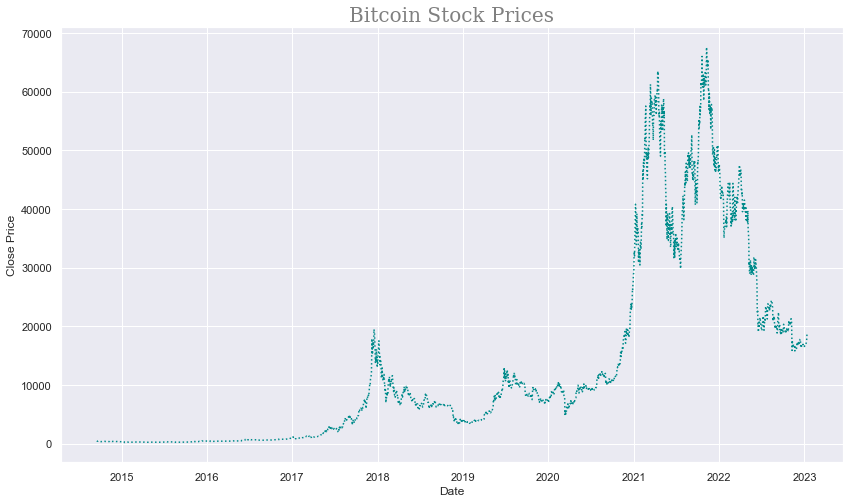

In [22]:
x1 = np.array(df_btc.date)
#x2 = 
y1 = np.array(df_btc.close)
#y2 = np.array(df_btc.close)

font1 = {'family':'serif','color':'gray','size':20}
sns.set_theme()

plt.figure(figsize=(14, 8))
plt.plot(x1,y1,ls = 'dotted',color = 'DarkCyan')
plt.title("Bitcoin Stock Prices", fontdict = font1)
plt.xlabel("Date")
plt.ylabel("Close Price")
#plt.legend(('xxx','xxx'))
#plt.ylim(50,400) (definir limite da escala do eito y)
plt.show()